# Multi-layer Perceptron (MLP)

## Libraries & Settings
---

In [86]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns  

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None) #show all columns
pd.set_option('display.max_rows', None) #show all rows


### Define Functions
---

In [88]:
def dummy_creator(feature_list, df):
    """
    Function to create dummy features and removes original categorical feature.
    
    Args: feature_list: list of features.
          df: dataframe.
          
    Returns: 
    Dataframe with new dummy features.
    
    """
    
    dummy_dfs = []
    
    for feat in feature_list:
        dummy_df = pd.get_dummies(df[feat], prefix=feat, dtype=int)
        dummy_dfs.append(dummy_df)
        df.drop(feat, axis=1, inplace=True)  
        
    df_with_dummies = pd.concat([df] + dummy_dfs, axis=1)
    
    return df_with_dummies

In [171]:
def mlp_build(n_features=len(X_train.columns),
              hidden_layer_sizes=[],
              activation='relu',
              optimizer='Adam',
              learning_rate=0.01):
    
    """Build a multi-layer perpectrong model using Keras.

    Args:
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use.
    learning_rate: The desired learning rate for the optimizer.

    Returns:
    A tf.keras model.
    
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    
    model.add(tf.keras.Input(shape=(n_features,), name='Input'))
    
    for idx, hidden_layer_size in enumerate(hidden_layer_sizes):
        
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                        activation=activation,
                                        use_bias=True,
                                        name='Hidden_'+str(idx)))
        
    model.add(tf.keras.layers.Dense(units=1, 
                                    activation='sigmoid',
                                    use_bias=True,
                                    name='Output'))
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=eval("tf.keras.optimizers." + optimizer + "(learning_rate="+ str(learning_rate) + ")"),
                  # metrics=['accuracy', tf.keras.metrics.AUC(name='prc', curve='PR')]
                  metrics=[tf.keras.metrics.AUC(name='prc', curve='PR')]
                 )

    return model

In [40]:
def mlp_train(num_epochs=5, batch=64, train_data=[None,None]):
    """
    
    Args:   num_epochs: the number of epochs
            batch: the batch size
            train_data: list with training data e.g train_data=[X_train, y_train]
    
    Outputs: The model.summary() and plots: loss, accuracy, and AUC-PRC.
    
    Returns: model
            
    """

    # Build the model
    model = mlp_build(n_features,
                      hidden_layer_sizes,
                      activation,
                      optimizer,
                      learning_rate)
    print(model.summary())

    # Train the model
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                  min_delta=5e-3,
                                                  patience=0,
                                                  verbose=1,
                                                  mode='auto',
                                                  restore_best_weights=False,
                                                  start_from_epoch=0)
    
    history = model.fit(x=train_data[0],
                        y=train_data[1],
                        epochs=num_epochs,
                        batch_size=batch,
                        validation_split=0.2,
                        verbose=1,
                        callbacks=[stop_early])
    
    # plot metrics
    metrics = [i for i in history.history.keys() if 'val_' not in i]
    x_ticks = np.array(history.epoch)+1
    
    fig = plt.figure(figsize=(6*len(metrics), 4))
    for idx, metric in enumerate(metrics):
        ax = fig.add_subplot(1, len(metrics), idx+1)
        ax.plot(x_ticks, history.history[metric], '-o', label='Training')
        ax.plot(x_ticks, history.history['val_'+metric], '-o', label='Validation')
        ax.legend(fontsize=13)
        ax.set_xlabel('epoch', size=15)
        ax.set_xticks(x_ticks)
        ax.set_title(metric, size=15)
        
    plt.show()
    
    return model
    

In [78]:
def mlp_train_val(num_epochs=5, batch=64, train_data=[None,None], val_data=(None,None)):
    """
    
    Args:   num_epochs: the number of epochs
            batch: the batch size
            train_data: list with training data e.g train_data = [X_train, y_train]
            val_data: tuple with validation data e.g. val_data = (X_val, y_val)
    
    Outputs: The model_summary() and plots: loss, accuracy, and AUC-PRC.
    
    Returns: model
            
    """

    # Build the model
    model = mlp_build(n_features,
                      hidden_layer_sizes,
                      activation,
                      optimizer,
                      learning_rate)
    print(model.summary())

    # Train the model
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                  min_delta=5e-3,
                                                  patience=0,
                                                  verbose=1,
                                                  mode='auto',
                                                  restore_best_weights=False,
                                                  start_from_epoch=0)
    
    history = model.fit(x=train_data[0],
                        y=train_data[1],
                        epochs=num_epochs,
                        batch_size=batch,
                        validation_data=val_data,
                        verbose=1,
                        callbacks=[stop_early])

    # plot metrics
    metrics = [i for i in history.history.keys() if 'val_' not in i]
    x_ticks = np.array(history.epoch)+1
    
    fig = plt.figure(figsize=(6*len(metrics), 4))
    for idx, metric in enumerate(metrics):
        ax = fig.add_subplot(1, len(metrics), idx+1)
        ax.plot(x_ticks, history.history[metric], '-o', label='Training')
        ax.plot(x_ticks, history.history['val_'+metric], '-o', label='Validation')
        ax.legend(fontsize=13)
        ax.set_xlabel('epoch', size=15)
        ax.set_xticks(x_ticks)
        ax.set_title(metric, size=15)
    
    plt.show()
    
    return model
    

#### Kaggle Competition Performance Metric:

$$\text{balanced} \log \text { Loss }=\frac{-\frac{1}{N_0} \sum_{i=1}^{N_0} y_{0 i} \log p_{0 i}-\frac{1}{N_1} \sum_{i=1}^{N_1} y_{1 i} \log p_{1 i}}{2}$$

In [28]:
def balanced_log_loss(y_true, y_pred):
    y_true, y_pred = y_true.flatten(), y_pred.flatten()
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

## Import & Preprocess Data
---

In [132]:
# read main data
data_df = pd.read_csv('../Kaggle_Files/train.csv')
print(f'Dataset Shape: {data_df.shape}')
data_df.head()

Dataset Shape: (617, 58)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [133]:
# read metadata
meta_df = pd.read_csv('../Kaggle_Files/greeks.csv')
print(f'Dataset Shape: {meta_df.shape}')
meta_df.head()

Dataset Shape: (617, 6)


,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [134]:
# merge data and metadata
merged_df = data_df.merge(meta_df, left_on='Id', right_on='Id')
print(f'Merged dataframe shape: {merged_df.shape}')
merged_df.head()

Merged dataframe shape: (617, 63)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


The features 'Alpha' and 'Gamma' are perfectly correlated to the labels, therefore they are dropped from the dataframe.
The 'Epsilon' feature contains date with missing values. For simplicity, we're working with the dataset as if it were cross-sectional.

In [135]:
# drop 'Alpha', 'Gamma', and 'Epsilon'

merged_df = merged_df.drop(['Id','Alpha', 'Gamma', 'Epsilon'], axis=1)
merged_df.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Beta',
       'Delta'],
      dtype='object')

In [136]:
# create dummy features for categorical features

dummy_list = ['EJ','Beta', 'Delta']
merged_df = dummy_creator(dummy_list, merged_df)
all_features = [i for i in merged_df.columns if i != 'Class']
print(all_features)
merged_df.head()

['AB' 'AF' 'AH' 'AM' 'AR' 'AX' 'AY' 'AZ' 'BC' 'BD ' 'BN' 'BP' 'BQ' 'BR'
 'BZ' 'CB' 'CC' 'CD ' 'CF' 'CH' 'CL' 'CR' 'CS' 'CU' 'CW ' 'DA' 'DE' 'DF'
 'DH' 'DI' 'DL' 'DN' 'DU' 'DV' 'DY' 'EB' 'EE' 'EG' 'EH' 'EL' 'EP' 'EU'
 'FC' 'FD ' 'FE' 'FI' 'FL' 'FR' 'FS' 'GB' 'GE' 'GF' 'GH' 'GI' 'GL' 'EJ_A'
 'EJ_B' 'Beta_A' 'Beta_B' 'Beta_C' 'Delta_A' 'Delta_B' 'Delta_C' 'Delta_D']


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,EJ_A,EJ_B,Beta_A,Beta_B,Beta_C,Delta_A,Delta_B,Delta_C,Delta_D
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,1,0,0,0,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,1,0,1,0,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0,1,0,0,1,0,1,0,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0,1,0,0,1,0,1,0,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,1,0,1,0,0,1,0,0


## Create Different Datasets for Ablation Study
---

In [163]:
# create original feature list
original_features = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
                     'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
                     'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
                     'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
                     'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL','EJ_A', 'EJ_B']

In [115]:
# create greek feature list
greek_features = ['Beta_A', 'Beta_B', 'Beta_C', 'Delta_A', 'Delta_B', 'Delta_C','Delta_D']

In [117]:
# create feature list using select features from Random Forrest modeling
select_features = ['DU', 'AB','BQ','GL','CR','DA','DI','AF','CC','EE','FR',
                   'DE','EB','DL','CD ','FE','DH','BC','FI','EU','BN', 'BP',
                   'CU', 'CB', 'DY', 'FC', 'DN', 'AM','EG','CS','GH','CF','GF',
                   'BD ','GI']

### Dataset with All Features

In [139]:
# split train/test

labels = ['Class']
y = merged_df[labels].values

X = merged_df[all_features].values


# shuffle and split
split = (0.8,0.2) #80% training and 20% test
shuffle = np.random.permutation(np.arange(y.shape[0])) 
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# recombine shuffled train and test dfs
train_df = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1)

test_df = pd.concat(
    [pd.DataFrame(y_test), pd.DataFrame(X_test)],
    axis=1)

# rename columns
train_df.columns = labels + all_features
test_df.columns = labels + all_features

train_df.head()

,Class,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B,Beta_A,Beta_B,Beta_C,Delta_A,Delta_B,Delta_C,Delta_D
0,1,6.161666,18964.47278,210.557493,85.393581,8.138688,17.983770,0.032886,8.866914,6.767964,7259.05083,19.0674,1027.410669,344.644105,740.681903,1510.069965,536.221322,NaN,633.534408,50.082229,0.082386,2.195925,0.665475,46.868767,1.164087,7.030640,23.91632,416.264665,0.556686,0.314295,311.516100,65.77300,62.808096,0.005518,3.04325,16.287992,27.713628,6.360918,6845.912275,0.003042,NaN,110.708936,132.899616,NaN,0.296850,5676.738604,12.768108,0.173229,54.94862,NaN,31.636102,296.036174,12261.844150,49.586046,39.457052,21.978,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0,0.247834,2267.05116,85.200147,14.884182,8.138688,6.369621,0.025578,14.727774,1.229900,5317.40093,19.4205,251.983116,22.255817,532.729381,257.432377,12.701962,0.714908,87.441876,4.150965,0.031044,1.050225,0.773925,28.181934,1.346148,36.154712,108.91936,787.190325,0.238680,0.243237,127.855635,73.48556,22.444136,0.005518,1.74307,13.053752,5.725080,2.196895,1842.704075,0.003042,69.513229,78.526968,37.939488,24.321696,0.296850,7340.165234,11.329215,0.173229,1.12810,0.067730,22.696880,72.611063,43395.398780,38.010015,39.180562,21.978,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0,0.162374,3245.45474,85.200147,14.469184,8.138688,4.208025,0.038671,8.009842,1.229900,4553.78065,28.2480,126.211986,102.845400,51.216883,257.432377,76.524266,0.653307,90.569472,9.063700,0.019502,1.050225,0.887175,31.498071,1.599930,7.030640,25.96884,569.130245,1.798173,0.319761,136.080277,116.36044,32.768848,0.006897,1.74307,0.988240,21.790644,1.842167,1488.997413,0.073008,109.125159,96.392966,6501.264480,25.109952,18.523440,15103.820970,9.350048,6.169800,0.88885,0.331877,17.915652,1228.992706,4256.400636,15.803087,105.475148,7.128,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,0.282018,2594.35253,85.200147,31.406677,8.138688,6.741699,0.025578,7.392246,4.736872,4942.51812,20.4798,173.455641,16.210915,2049.080603,257.432377,59.539298,0.750318,151.218672,11.011461,0.022288,1.107510,0.847725,32.448279,2.113011,37.798844,74.90728,685.047840,0.238680,0.412683,130.086398,94.24672,28.647152,0.006897,1.74307,27.077776,8.354376,4.373635,1092.540363,0.073008,19.403241,78.526968,4.631028,39.538464,2.119509,6490.017644,16.583104,0.705967,0.60755,0.121914,21.692264,72.611063,1731.843747,28.045177,23.263740,7.128,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0,0.196558,192.59328,85.200147,17.835623,9.659448,0.699861,0.025578,8.955142,10.281964,5860.15364,17.6550,250.317189,45.842790,51.216883,257.432377,140.199514,0.536908,23.387600,13.565901,0.022487,1.050225,0.069225,30.183472,2.424721,37.326240,56.34924,103.805610,0.238680,0.583495,145.351590,143.20282,25.085024,0.005518,1.74307,20.950688,7.272972,2.112244,1353.727125,0.003042,109.125159,78.526968,3.828384,8.607984,0.296850,14220.001360,3.583450,0.173229,1.29630,0.067730,21.524828,72.611063,34569.729670,17.016133,78.813796,21.978,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [140]:
# columns with missing values 
sum_null = train_df.isnull().sum()
sum_null[sum_null != 0]

BQ    49
CB     1
CC     2
DU     1
EL    48
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [141]:
# mean imputation
train_mean_vals = train_df.mean()

train_df = train_df.fillna(train_mean_vals, inplace=False)
test_df = test_df.fillna(train_mean_vals, inplace=False)

In [142]:
# columns with missing values 
sum_null = train_df.isnull().sum()
sum_null[sum_null != 0]

Series([], dtype: int64)

In [157]:
# split features from label
X_train_all = train_df[all_features]
y_train = train_df[labels].values
X_test_all = test_df[all_features]
y_test = test_df[labels].values

In [158]:
# standardize features
sc = StandardScaler()

X_train_all_std = sc.fit(X_train_all).transform(X_train_all)
X_test_all_std = sc.fit(X_train_all).transform(X_test_all)

In [160]:
# check features
X_train_all.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B,Beta_A,Beta_B,Beta_C,Delta_A,Delta_B,Delta_C,Delta_D
0,6.161666,18964.47278,210.557493,85.393581,8.138688,17.983770,0.032886,8.866914,6.767964,7259.05083,19.0674,1027.410669,344.644105,740.681903,1510.069965,536.221322,0.692364,633.534408,50.082229,0.082386,2.195925,0.665475,46.868767,1.164087,7.030640,23.91632,416.264665,0.556686,0.314295,311.516100,65.77300,62.808096,0.005518,3.04325,16.287992,27.713628,6.360918,6845.912275,0.003042,70.017052,110.708936,132.899616,73.075892,0.296850,5676.738604,12.768108,0.173229,54.94862,0.432782,31.636102,296.036174,12261.844150,49.586046,39.457052,21.978,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.247834,2267.05116,85.200147,14.884182,8.138688,6.369621,0.025578,14.727774,1.229900,5317.40093,19.4205,251.983116,22.255817,532.729381,257.432377,12.701962,0.714908,87.441876,4.150965,0.031044,1.050225,0.773925,28.181934,1.346148,36.154712,108.91936,787.190325,0.238680,0.243237,127.855635,73.48556,22.444136,0.005518,1.74307,13.053752,5.725080,2.196895,1842.704075,0.003042,69.513229,78.526968,37.939488,24.321696,0.296850,7340.165234,11.329215,0.173229,1.12810,0.067730,22.696880,72.611063,43395.398780,38.010015,39.180562,21.978,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.162374,3245.45474,85.200147,14.469184,8.138688,4.208025,0.038671,8.009842,1.229900,4553.78065,28.2480,126.211986,102.845400,51.216883,257.432377,76.524266,0.653307,90.569472,9.063700,0.019502,1.050225,0.887175,31.498071,1.599930,7.030640,25.96884,569.130245,1.798173,0.319761,136.080277,116.36044,32.768848,0.006897,1.74307,0.988240,21.790644,1.842167,1488.997413,0.073008,109.125159,96.392966,6501.264480,25.109952,18.523440,15103.820970,9.350048,6.169800,0.88885,0.331877,17.915652,1228.992706,4256.400636,15.803087,105.475148,7.128,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.282018,2594.35253,85.200147,31.406677,8.138688,6.741699,0.025578,7.392246,4.736872,4942.51812,20.4798,173.455641,16.210915,2049.080603,257.432377,59.539298,0.750318,151.218672,11.011461,0.022288,1.107510,0.847725,32.448279,2.113011,37.798844,74.90728,685.047840,0.238680,0.412683,130.086398,94.24672,28.647152,0.006897,1.74307,27.077776,8.354376,4.373635,1092.540363,0.073008,19.403241,78.526968,4.631028,39.538464,2.119509,6490.017644,16.583104,0.705967,0.60755,0.121914,21.692264,72.611063,1731.843747,28.045177,23.263740,7.128,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.196558,192.59328,85.200147,17.835623,9.659448,0.699861,0.025578,8.955142,10.281964,5860.15364,17.6550,250.317189,45.842790,51.216883,257.432377,140.199514,0.536908,23.387600,13.565901,0.022487,1.050225,0.069225,30.183472,2.424721,37.326240,56.34924,103.805610,0.238680,0.583495,145.351590,143.20282,25.085024,0.005518,1.74307,20.950688,7.272972,2.112244,1353.727125,0.003042,109.125159,78.526968,3.828384,8.607984,0.296850,14220.001360,3.583450,0.173229,1.29630,0.067730,21.524828,72.611063,34569.729670,17.016133,78.813796,21.978,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Dataset with Original Features

In [164]:
# split features from label
X_train_orig = X_train_all[original_features]
X_test_orig = X_test_all[original_features]

# standardize features
X_train_orig_std = sc.fit(X_train_orig).transform(X_train_orig)
X_test_orig_std = sc.fit(X_train_orig).transform(X_test_orig)

X_train_orig.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
0,6.161666,18964.47278,210.557493,85.393581,8.138688,17.983770,0.032886,8.866914,6.767964,7259.05083,19.0674,1027.410669,344.644105,740.681903,1510.069965,536.221322,0.692364,633.534408,50.082229,0.082386,2.195925,0.665475,46.868767,1.164087,7.030640,23.91632,416.264665,0.556686,0.314295,311.516100,65.77300,62.808096,0.005518,3.04325,16.287992,27.713628,6.360918,6845.912275,0.003042,70.017052,110.708936,132.899616,73.075892,0.296850,5676.738604,12.768108,0.173229,54.94862,0.432782,31.636102,296.036174,12261.844150,49.586046,39.457052,21.978,1.0,0.0
1,0.247834,2267.05116,85.200147,14.884182,8.138688,6.369621,0.025578,14.727774,1.229900,5317.40093,19.4205,251.983116,22.255817,532.729381,257.432377,12.701962,0.714908,87.441876,4.150965,0.031044,1.050225,0.773925,28.181934,1.346148,36.154712,108.91936,787.190325,0.238680,0.243237,127.855635,73.48556,22.444136,0.005518,1.74307,13.053752,5.725080,2.196895,1842.704075,0.003042,69.513229,78.526968,37.939488,24.321696,0.296850,7340.165234,11.329215,0.173229,1.12810,0.067730,22.696880,72.611063,43395.398780,38.010015,39.180562,21.978,1.0,0.0
2,0.162374,3245.45474,85.200147,14.469184,8.138688,4.208025,0.038671,8.009842,1.229900,4553.78065,28.2480,126.211986,102.845400,51.216883,257.432377,76.524266,0.653307,90.569472,9.063700,0.019502,1.050225,0.887175,31.498071,1.599930,7.030640,25.96884,569.130245,1.798173,0.319761,136.080277,116.36044,32.768848,0.006897,1.74307,0.988240,21.790644,1.842167,1488.997413,0.073008,109.125159,96.392966,6501.264480,25.109952,18.523440,15103.820970,9.350048,6.169800,0.88885,0.331877,17.915652,1228.992706,4256.400636,15.803087,105.475148,7.128,0.0,1.0
3,0.282018,2594.35253,85.200147,31.406677,8.138688,6.741699,0.025578,7.392246,4.736872,4942.51812,20.4798,173.455641,16.210915,2049.080603,257.432377,59.539298,0.750318,151.218672,11.011461,0.022288,1.107510,0.847725,32.448279,2.113011,37.798844,74.90728,685.047840,0.238680,0.412683,130.086398,94.24672,28.647152,0.006897,1.74307,27.077776,8.354376,4.373635,1092.540363,0.073008,19.403241,78.526968,4.631028,39.538464,2.119509,6490.017644,16.583104,0.705967,0.60755,0.121914,21.692264,72.611063,1731.843747,28.045177,23.263740,7.128,0.0,1.0
4,0.196558,192.59328,85.200147,17.835623,9.659448,0.699861,0.025578,8.955142,10.281964,5860.15364,17.6550,250.317189,45.842790,51.216883,257.432377,140.199514,0.536908,23.387600,13.565901,0.022487,1.050225,0.069225,30.183472,2.424721,37.326240,56.34924,103.805610,0.238680,0.583495,145.351590,143.20282,25.085024,0.005518,1.74307,20.950688,7.272972,2.112244,1353.727125,0.003042,109.125159,78.526968,3.828384,8.607984,0.296850,14220.001360,3.583450,0.173229,1.29630,0.067730,21.524828,72.611063,34569.729670,17.016133,78.813796,21.978,1.0,0.0


### Dataset with Greek Features

In [165]:
# split features from label
X_train_greek = X_train_all[greek_features]
X_test_greek = X_test_all[greek_features]

# standardize features
X_train_greek_std = sc.fit(X_train_greek).transform(X_train_greek)
X_test_greek_std = sc.fit(X_train_greek).transform(X_test_greek)

X_train_greek.head()

,Beta_A,Beta_B,Beta_C,Delta_A,Delta_B,Delta_C,Delta_D
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Dataset with Select Features

In [166]:
# split features from label
X_train_select = X_train_all[select_features]
X_test_select = X_test_all[select_features]

# standardize features
X_train_select_std = sc.fit(X_train_select).transform(X_train_select)
X_test_select_std = sc.fit(X_train_select).transform(X_test_select)

X_train_select.head()

,DU,AB,BQ,GL,CR,DA,DI,AF,CC,EE,FR,DE,EB,DL,CD,FE,DH,BC,FI,EU,BN,BP,CU,CB,DY,FC,DN,AM,EG,CS,GH,CF,GF,BD,GI
0,0.005518,6.161666,344.644105,21.978,0.665475,23.91632,311.516100,18964.47278,0.692364,6.360918,54.94862,416.264665,27.713628,65.77300,633.534408,5676.738604,0.314295,6.767964,12.768108,132.899616,19.0674,1027.410669,1.164087,536.221322,16.287992,73.075892,62.808096,85.393581,6845.912275,46.868767,49.586046,50.082229,12261.844150,7259.05083,39.457052
1,0.005518,0.247834,22.255817,21.978,0.773925,108.91936,127.855635,2267.05116,0.714908,2.196895,1.12810,787.190325,5.725080,73.48556,87.441876,7340.165234,0.243237,1.229900,11.329215,37.939488,19.4205,251.983116,1.346148,12.701962,13.053752,24.321696,22.444136,14.884182,1842.704075,28.181934,38.010015,4.150965,43395.398780,5317.40093,39.180562
2,0.006897,0.162374,102.845400,7.128,0.887175,25.96884,136.080277,3245.45474,0.653307,1.842167,0.88885,569.130245,21.790644,116.36044,90.569472,15103.820970,0.319761,1.229900,9.350048,6501.264480,28.2480,126.211986,1.599930,76.524266,0.988240,25.109952,32.768848,14.469184,1488.997413,31.498071,15.803087,9.063700,4256.400636,4553.78065,105.475148
3,0.006897,0.282018,16.210915,7.128,0.847725,74.90728,130.086398,2594.35253,0.750318,4.373635,0.60755,685.047840,8.354376,94.24672,151.218672,6490.017644,0.412683,4.736872,16.583104,4.631028,20.4798,173.455641,2.113011,59.539298,27.077776,39.538464,28.647152,31.406677,1092.540363,32.448279,28.045177,11.011461,1731.843747,4942.51812,23.263740
4,0.005518,0.196558,45.842790,21.978,0.069225,56.34924,145.351590,192.59328,0.536908,2.112244,1.29630,103.805610,7.272972,143.20282,23.387600,14220.001360,0.583495,10.281964,3.583450,3.828384,17.6550,250.317189,2.424721,140.199514,20.950688,8.607984,25.085024,17.835623,1353.727125,30.183472,17.016133,13.565901,34569.729670,5860.15364,78.813796


### Dataset with Select and Greek Features

In [167]:
# split features from label
X_train_select_greek = X_train_all[select_features+greek_features]
X_test_select_greek = X_test_all[select_features+greek_features]

# standardize features
X_train_select_greek_std = sc.fit(X_train_select_greek).transform(X_train_select_greek)
X_test_select_greek_std = sc.fit(X_train_select_greek).transform(X_test_select_greek)

X_train_select_greek.head()

,DU,AB,BQ,GL,CR,DA,DI,AF,CC,EE,FR,DE,EB,DL,CD,FE,DH,BC,FI,EU,BN,BP,CU,CB,DY,FC,DN,AM,EG,CS,GH,CF,GF,BD,GI,Beta_A,Beta_B,Beta_C,Delta_A,Delta_B,Delta_C,Delta_D
0,0.005518,6.161666,344.644105,21.978,0.665475,23.91632,311.516100,18964.47278,0.692364,6.360918,54.94862,416.264665,27.713628,65.77300,633.534408,5676.738604,0.314295,6.767964,12.768108,132.899616,19.0674,1027.410669,1.164087,536.221322,16.287992,73.075892,62.808096,85.393581,6845.912275,46.868767,49.586046,50.082229,12261.844150,7259.05083,39.457052,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.005518,0.247834,22.255817,21.978,0.773925,108.91936,127.855635,2267.05116,0.714908,2.196895,1.12810,787.190325,5.725080,73.48556,87.441876,7340.165234,0.243237,1.229900,11.329215,37.939488,19.4205,251.983116,1.346148,12.701962,13.053752,24.321696,22.444136,14.884182,1842.704075,28.181934,38.010015,4.150965,43395.398780,5317.40093,39.180562,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.006897,0.162374,102.845400,7.128,0.887175,25.96884,136.080277,3245.45474,0.653307,1.842167,0.88885,569.130245,21.790644,116.36044,90.569472,15103.820970,0.319761,1.229900,9.350048,6501.264480,28.2480,126.211986,1.599930,76.524266,0.988240,25.109952,32.768848,14.469184,1488.997413,31.498071,15.803087,9.063700,4256.400636,4553.78065,105.475148,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.006897,0.282018,16.210915,7.128,0.847725,74.90728,130.086398,2594.35253,0.750318,4.373635,0.60755,685.047840,8.354376,94.24672,151.218672,6490.017644,0.412683,4.736872,16.583104,4.631028,20.4798,173.455641,2.113011,59.539298,27.077776,39.538464,28.647152,31.406677,1092.540363,32.448279,28.045177,11.011461,1731.843747,4942.51812,23.263740,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.005518,0.196558,45.842790,21.978,0.069225,56.34924,145.351590,192.59328,0.536908,2.112244,1.29630,103.805610,7.272972,143.20282,23.387600,14220.001360,0.583495,10.281964,3.583450,3.828384,17.6550,250.317189,2.424721,140.199514,20.950688,8.607984,25.085024,17.835623,1353.727125,30.183472,17.016133,13.565901,34569.729670,5860.15364,78.813796,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Dataset with Class Balancing

Label Counts:
0    509
1    108
Name: Class, dtype: int64


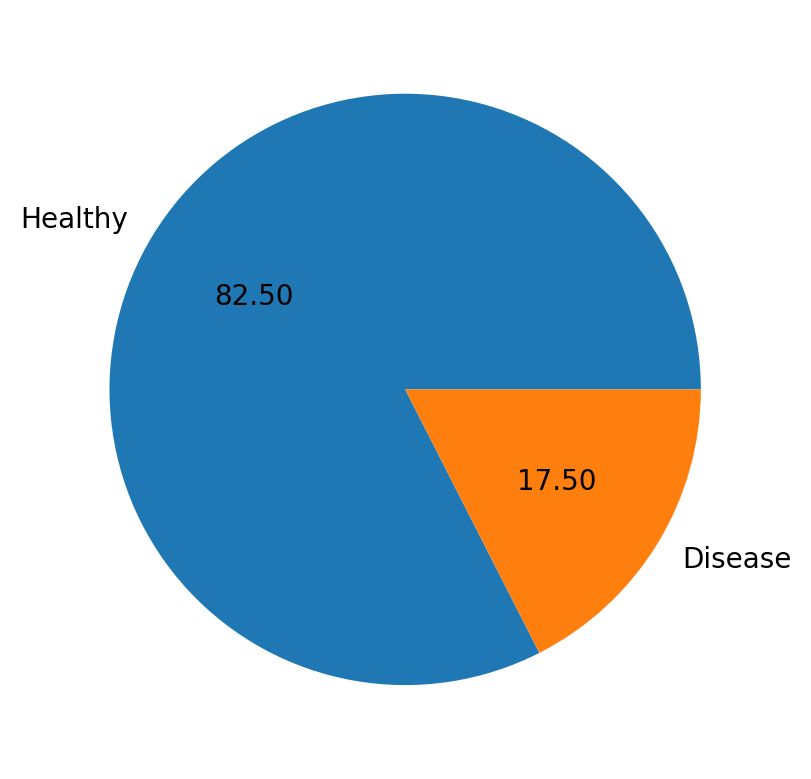

In [71]:
# check class imbalance
class_values_cnts = merged_df['Class'].value_counts()
print(f'Label Counts:\n{class_values_cnts}')
plt.pie(class_values_cnts, labels=['Healthy', 'Disease'], autopct='%.2f')
plt.show()

In [72]:
# split 60/20/20
bal_test_df  = merged_df.sample(frac=0.2, random_state=0)
bal_temp_df  = merged_df.drop(bal_test_df.index)
bal_val_df   = bal_temp_df.sample(frac=0.25, random_state=0)
bal_train_df = bal_temp_df.drop(bal_val_df.index)


In [73]:
# mean imputation
bal_train_means = bal_train_df.mean()

bal_train_df = bal_train_df.fillna(bal_train_means, inplace=False)
bal_val_df = bal_val_df.fillna(bal_train_means, inplace=False)
bal_test_df = bal_test_df.fillna(bal_train_means, inplace=False)


In [74]:
# downsampling train set
print(f'Class distribution before balancing:\n{bal_train_df.Class.value_counts()}')

class0_train_df = bal_train_df[bal_train_df.Class.eq(0)]
class1_train_df = bal_train_df[bal_train_df.Class.eq(1)]

class0_ds_train_df = class0_train_df.sample(n=len(class1_train_df), replace=False, axis=0, 
                                            random_state=0, ignore_index=False)
bal_train_df = pd.concat([class0_ds_train_df, class1_train_df], axis=0)

print(f'\nClass distribution after balancing:\n{bal_train_df.Class.value_counts()}')

Class distribution before balancing:
0    303
1     67
Name: Class, dtype: int64

Class distribution after balancing:
0    67
1    67
Name: Class, dtype: int64


In [75]:
#shuffle balanced datasets
bal_train_df = bal_train_df.sample(frac=1, random_state=0, ignore_index=True)
bal_val_df   = bal_val_df.sample(frac=1, random_state=0, ignore_index=True)
bal_test_df  = bal_test_df.sample(frac=1, random_state=0, ignore_index=True)

In [76]:
# split features from labels
X_train_bal_df = bal_train_df[features]
y_train_bal    = bal_train_df[labels].values
X_val_bal_df   = bal_val_df[features]
y_val_bal      = bal_val_df[labels].values
X_test_bal_df  = bal_test_df[features]
y_test_bal     = bal_test_df[labels].values

In [77]:
# standardize features
sc = StandardScaler()

X_train_bal_std = sc.fit(X_train_bal_df).transform(X_train_bal_df)
X_val_bal_std   = sc.fit(X_train_bal_df).transform(X_val_bal_df)
X_test_bal_std  = sc.fit(X_train_bal_df).transform(X_test_bal_df)

## Build & Train MLP Models with Different Datasets
---

- X_train_all_std
- X_train_orig_std
- X_train_select_std
- X_train_greek_std
- X_train_select_greek_std
- X_train_bal_std

### Hyperparameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 40)                2600      
                                                                 
 Output (Dense)              (None, 1)                 41        
                                                                 
Total params: 2641 (10.32 KB)
Trainable params: 2641 (10.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 [==============================] - 1s 120ms/step - loss: 1.1120 - prc: 0.4208 - val_loss: 0.7319 - val_prc: 0.6601
Epoch 2/50
7/7 [==============================] - 0s 32ms/step - loss: 0.5333 - prc: 0.6741 - val_loss: 0.4685 - val_prc: 0.7074
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 0.3250 - prc: 0.7758 - val_loss: 0.3638 - val_prc: 0.7491
Epoch 4/50
7/7 [=========

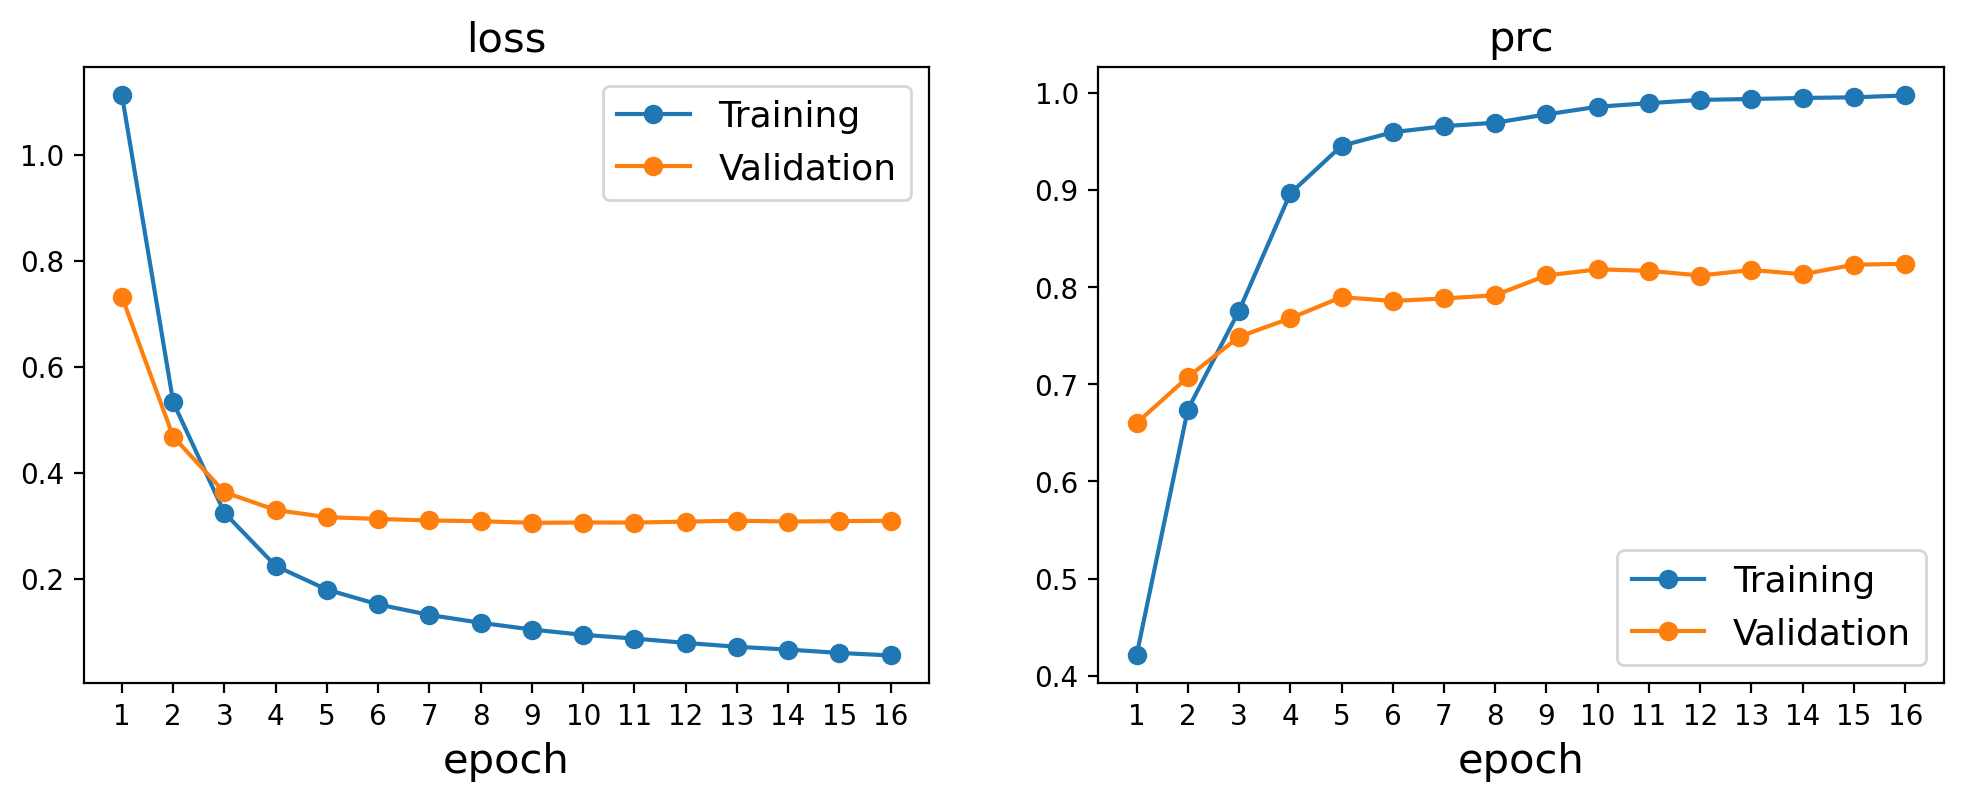

In [181]:
# all features
train_data=[X_train_all_std, y_train]
n_features=len(all_features)
hidden_layer_sizes=[40]
activation='relu'
optimizer='Adam'
learning_rate=0.005
num_epochs=50
batch=64

model = mlp_train(num_epochs, batch, train_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 30)                1740      
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 1771 (6.92 KB)
Trainable params: 1771 (6.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 [==============================] - 1s 132ms/step - loss: 0.7518 - prc: 0.3443 - val_loss: 0.5176 - val_prc: 0.6319
Epoch 2/50
7/7 [==============================] - 0s 38ms/step - loss: 0.4171 - prc: 0.6406 - val_loss: 0.4001 - val_prc: 0.7055
Epoch 3/50
7/7 [==============================] - 0s 31ms/step - loss: 0.3082 - prc: 0.7379 - val_loss: 0.3522 - val_prc: 0.7385
Epoch 4/50
7/7 [===========

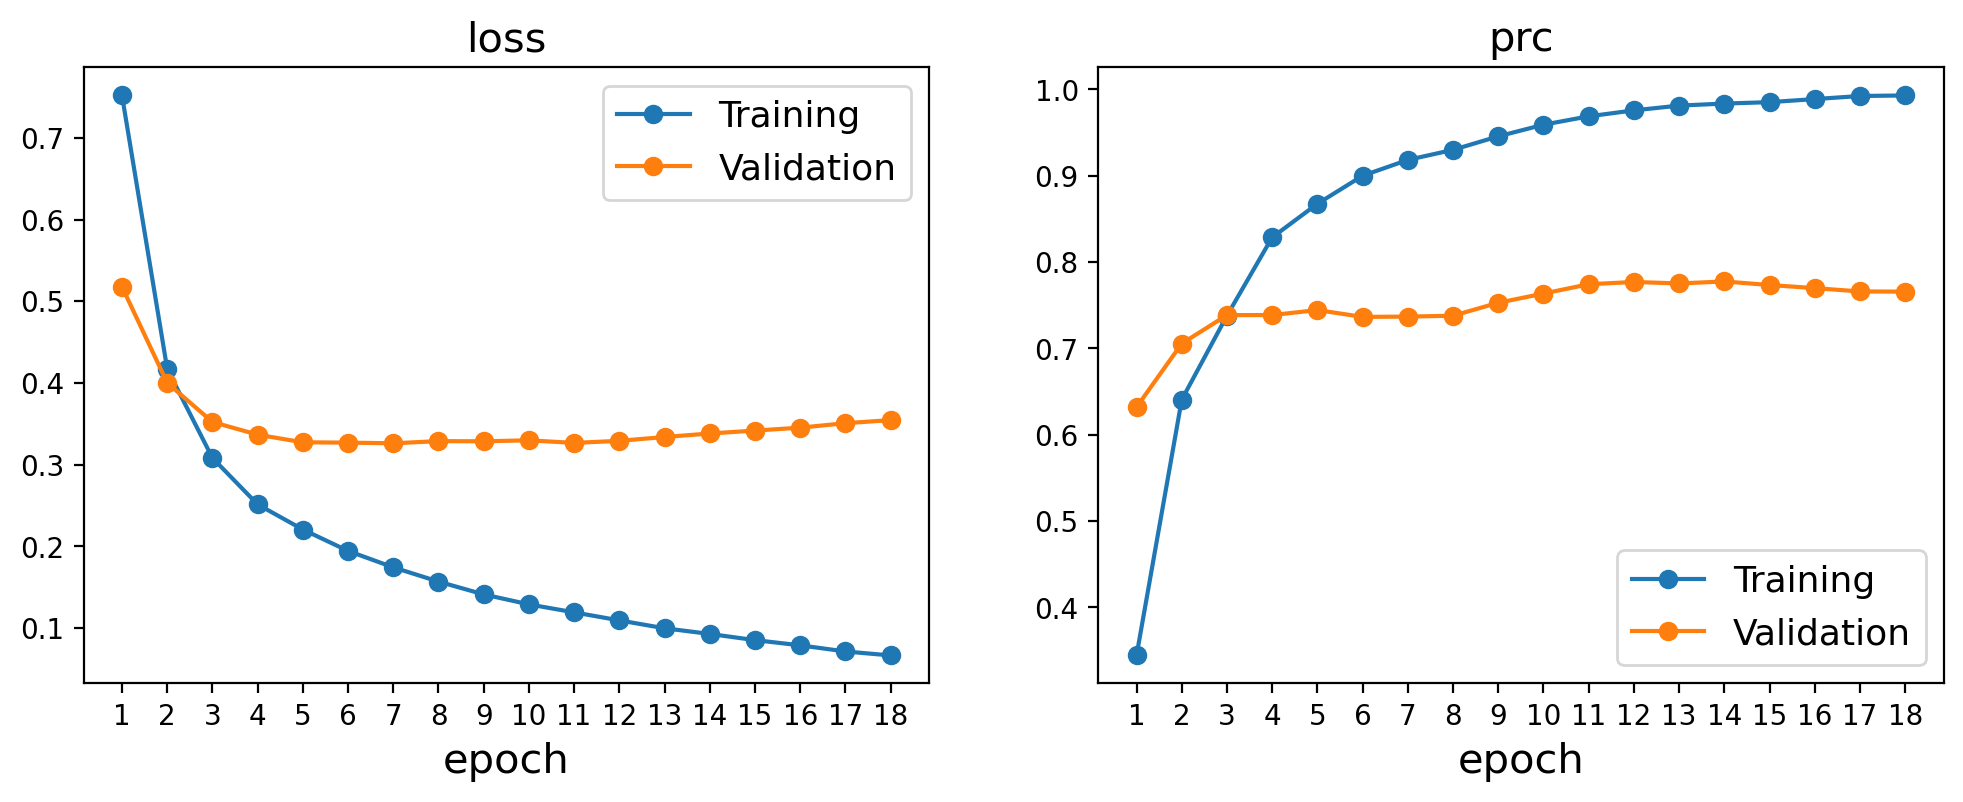

In [185]:
# original features
train_data=[X_train_orig_std, y_train]
n_features=len(original_features)
hidden_layer_sizes=[30]
activation='relu'
optimizer='Adam'
learning_rate=0.005
num_epochs=50
batch=64

model = mlp_train(num_epochs, batch, train_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 30)                1080      
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 1111 (4.34 KB)
Trainable params: 1111 (4.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 [==============================] - 1s 148ms/step - loss: 0.8157 - prc: 0.1529 - val_loss: 0.6884 - val_prc: 0.2269
Epoch 2/50
7/7 [==============================] - 0s 40ms/step - loss: 0.5390 - prc: 0.3847 - val_loss: 0.5309 - val_prc: 0.4001
Epoch 3/50
7/7 [==============================] - 0s 33ms/step - loss: 0.4048 - prc: 0.5801 - val_loss: 0.4537 - val_prc: 0.5080
Epoch 4/50
7/7 [===========

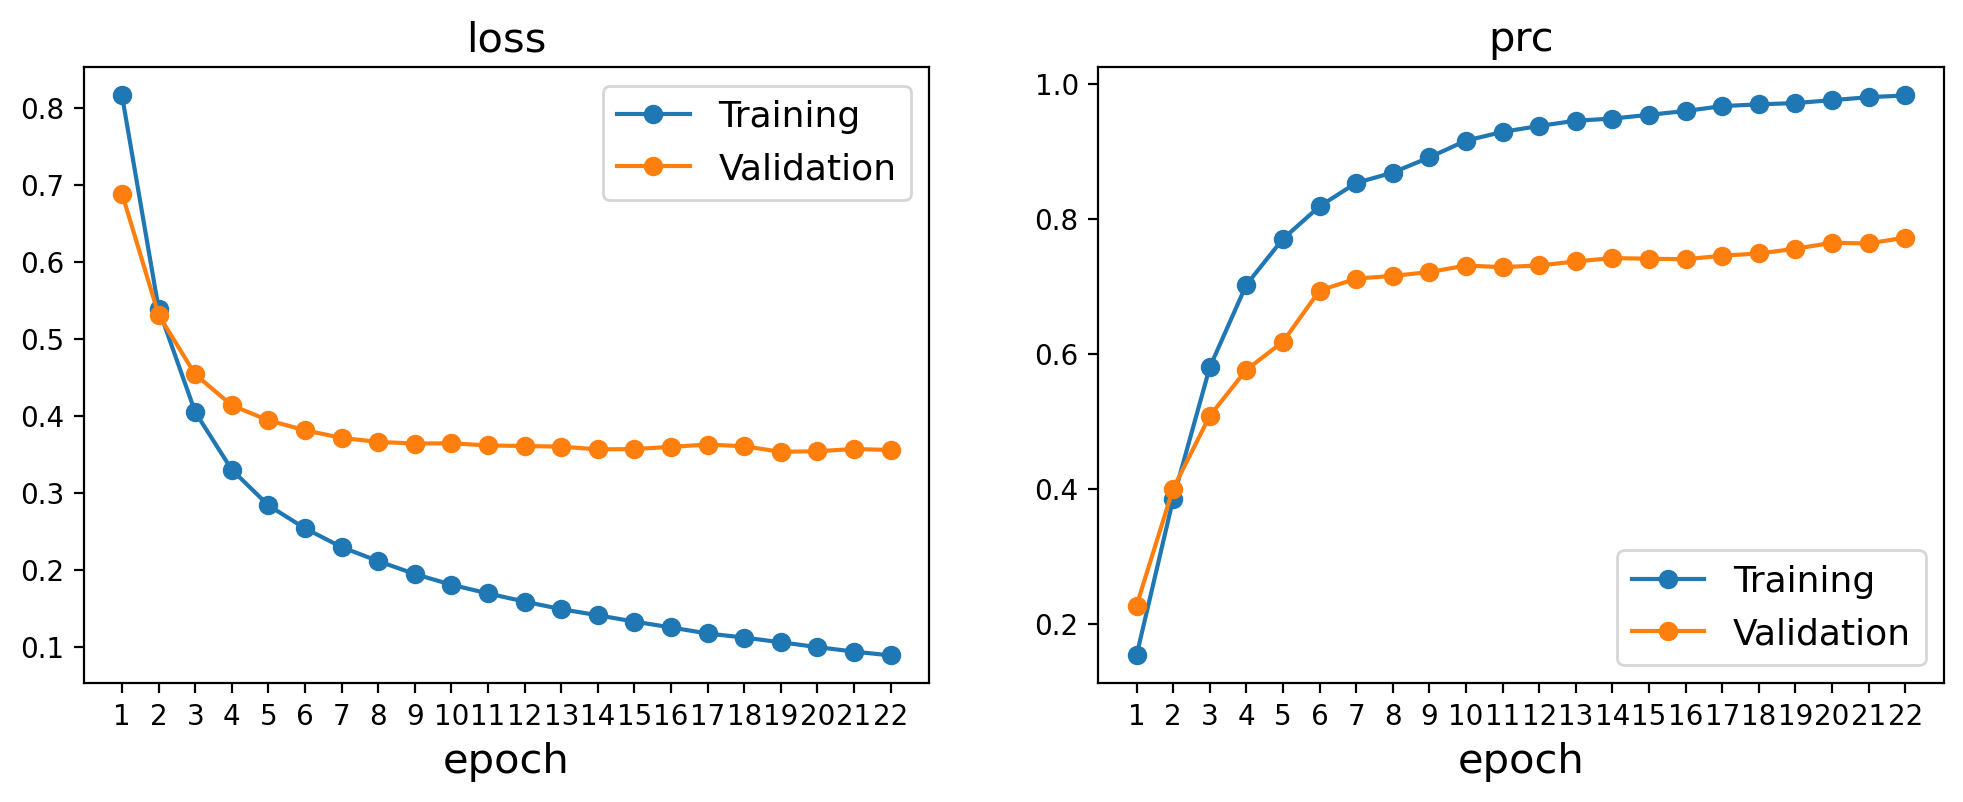

In [187]:
# select features
train_data=[X_train_select_std, y_train]
n_features=len(select_features)
hidden_layer_sizes=[30]
activation='relu'
optimizer='Adam'
learning_rate=0.005
num_epochs=50
batch=64

model = mlp_train(num_epochs, batch, train_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 30)                240       
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 271 (1.06 KB)
Trainable params: 271 (1.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 [==============================] - 1s 136ms/step - loss: 0.7776 - prc: 0.3547 - val_loss: 0.7008 - val_prc: 0.5252
Epoch 2/50
7/7 [==============================] - 0s 45ms/step - loss: 0.7326 - prc: 0.3805 - val_loss: 0.6666 - val_prc: 0.5453
Epoch 3/50
7/7 [==============================] - 0s 31ms/step - loss: 0.6943 - prc: 0.3463 - val_loss: 0.6350 - val_prc: 0.5453
Epoch 4/50
7/7 [=============

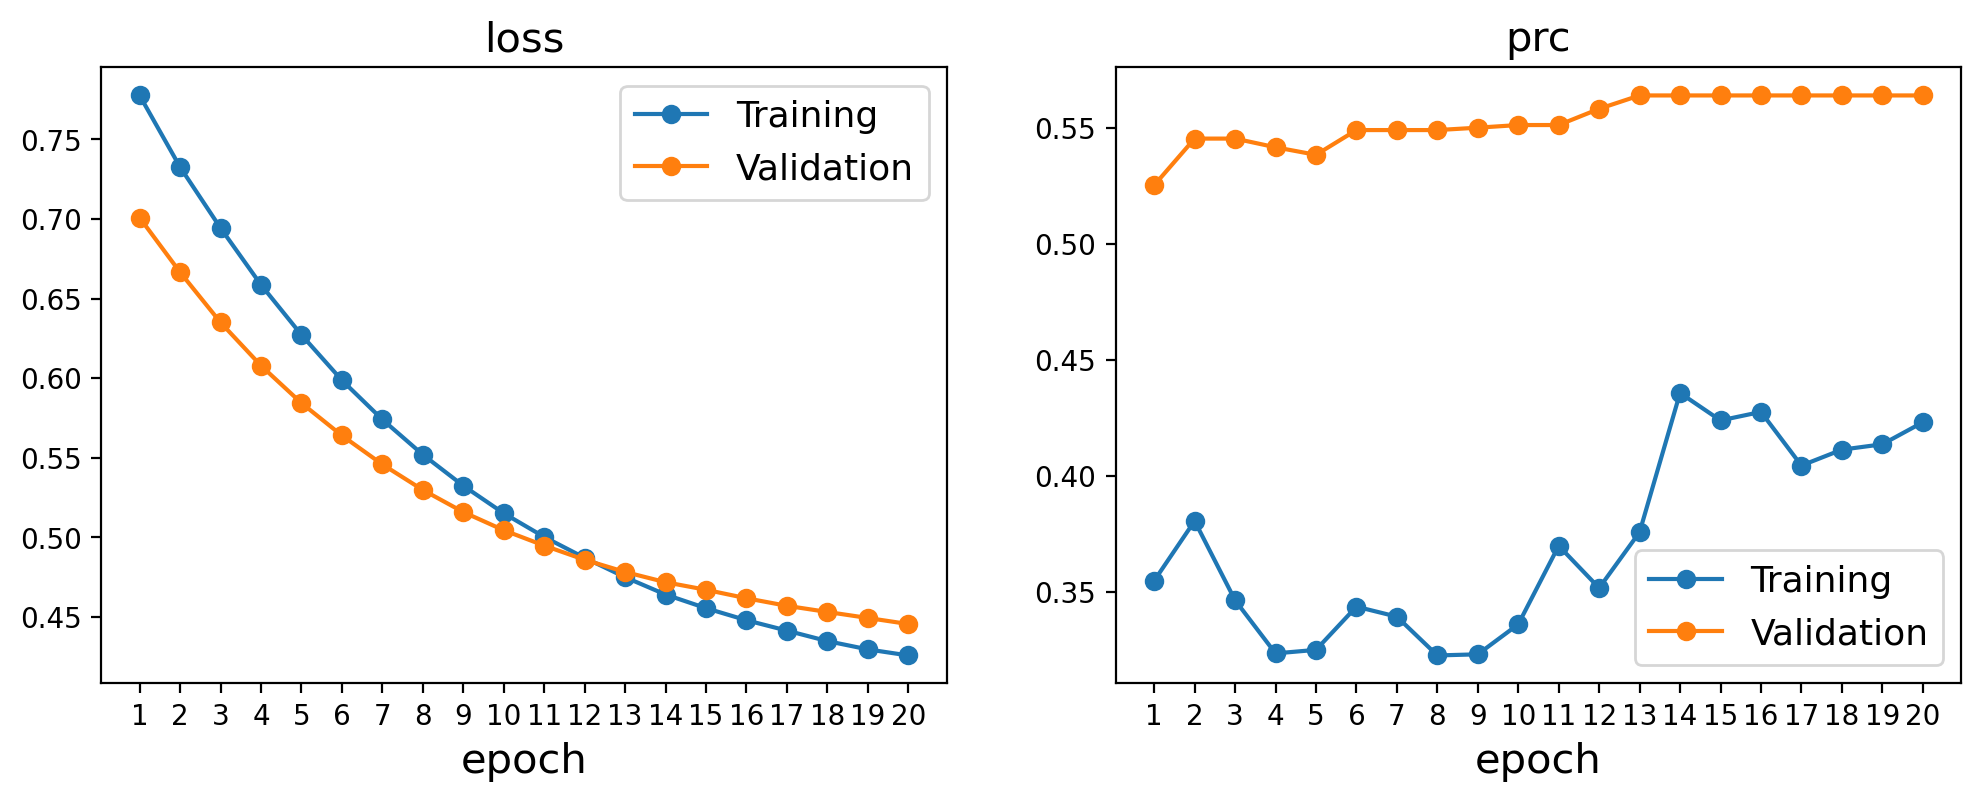

In [190]:
# greek features
train_data=[X_train_greek_std, y_train]
n_features=len(greek_features)
hidden_layer_sizes=[30]
activation='relu'
optimizer='Adam'
learning_rate=0.001
num_epochs=50
batch=64

model = mlp_train(num_epochs, batch, train_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 30)                1290      
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 1321 (5.16 KB)
Trainable params: 1321 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 [==============================] - 2s 221ms/step - loss: 0.9511 - prc: 0.4581 - val_loss: 0.8061 - val_prc: 0.6926
Epoch 2/50
7/7 [==============================] - 0s 42ms/step - loss: 0.8618 - prc: 0.5138 - val_loss: 0.7396 - val_prc: 0.7305
Epoch 3/50
7/7 [==============================] - 0s 32ms/step - loss: 0.7900 - prc: 0.5374 - val_loss: 0.6783 - val_prc: 0.7521
Epoch 4/50
7/7 [===========

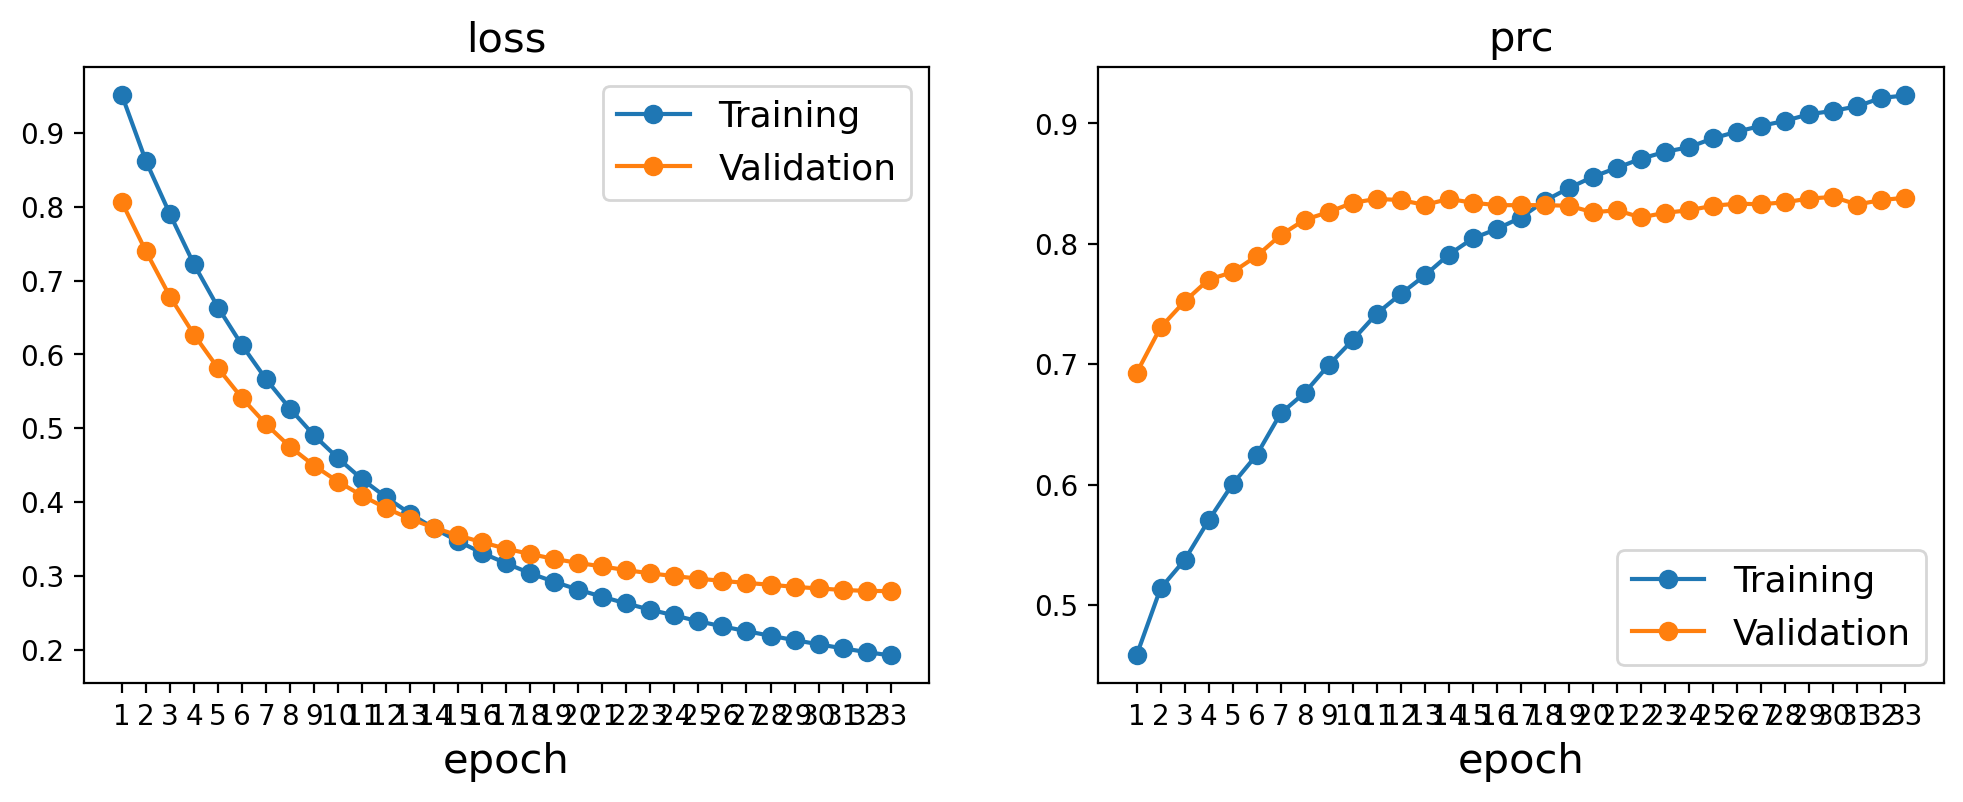

In [191]:
# select + greek features
train_data=[X_train_select_greek_std, y_train]
n_features=len(select_features+greek_features)
hidden_layer_sizes=[30]
activation='relu'
optimizer='Adam'
learning_rate=0.001
num_epochs=50
batch=64

model = mlp_train(num_epochs, batch, train_data)

## Train MLP Model with Separate Validation Data using Balanced Dataset
---

### Hyperparameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 15)                975       
                                                                 
 Output (Dense)              (None, 1)                 16        
                                                                 
Total params: 991 (3.87 KB)
Trainable params: 991 (3.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
3/3 [==============================] - 1s 482ms/step - loss: 0.9303 - prc: 0.4840 - val_loss: 1.0337 - val_prc: 0.1888
Epoch 2/50
3/3 [==============================] - 0s 81ms/step - loss: 0.7297 - prc: 0.6479 - val_loss: 0.9250 - val_prc: 0.2820
Epoch 3/50
3/3 [==============================] - 0s 76ms/step - loss: 0.5955 - prc: 0.7924 - val_loss: 0.8333 - val_prc: 0.3490
Epoch 4/50
3/3 [=============

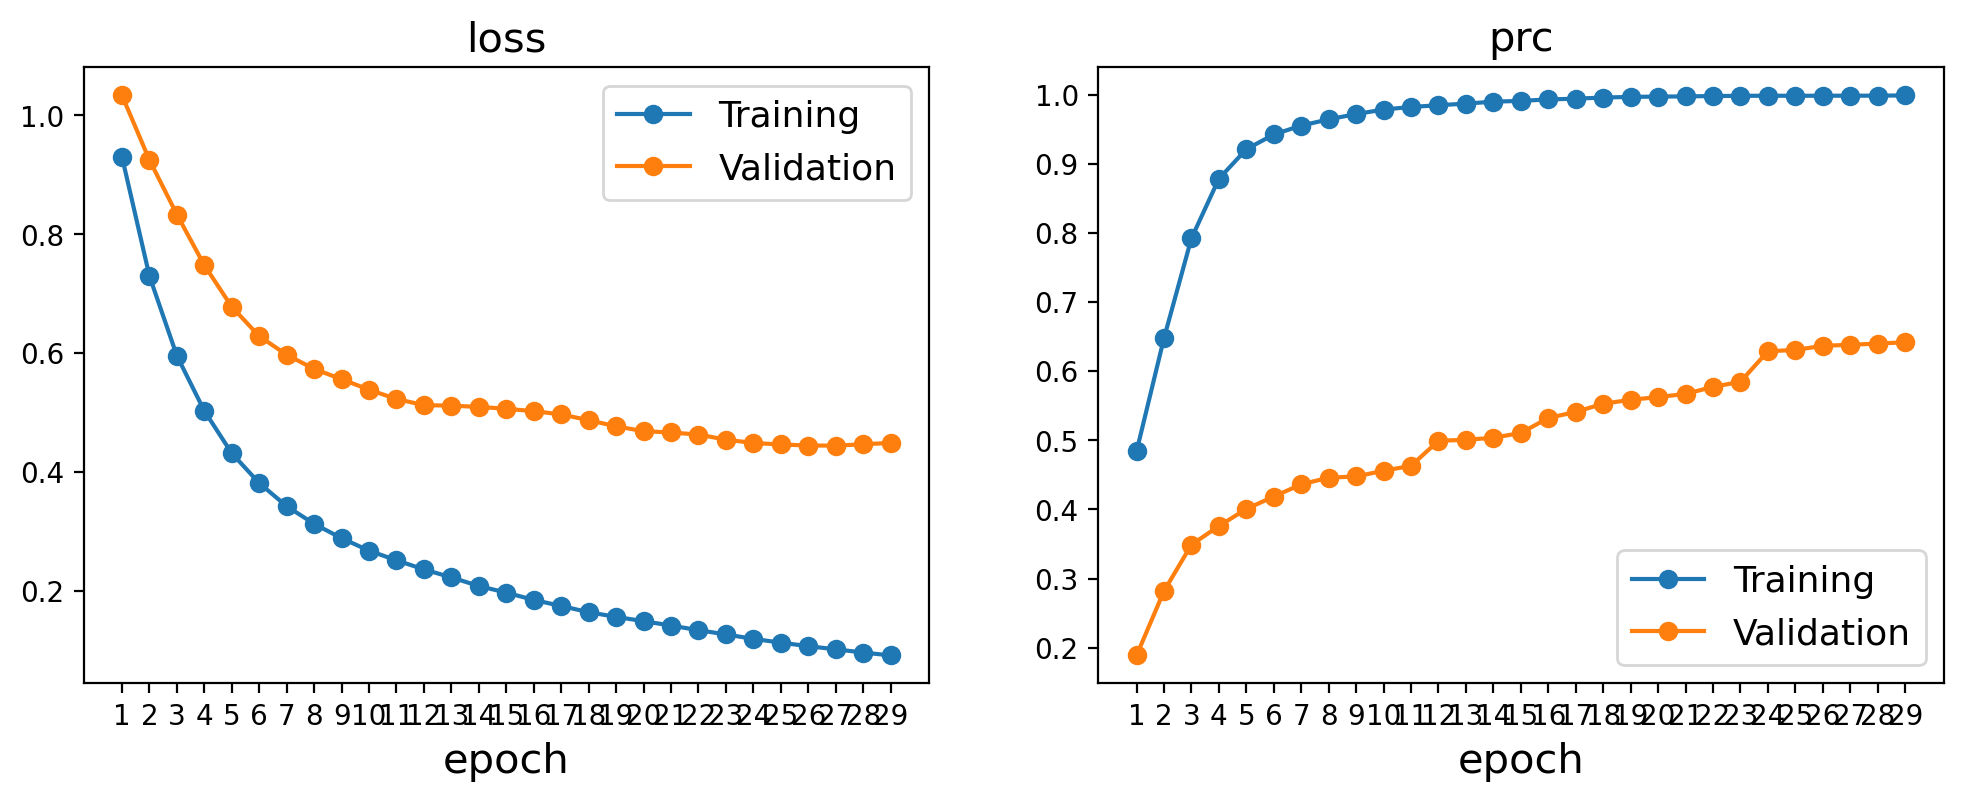

In [197]:
train_data = [X_train_bal_std, y_train_bal]
val_data = (X_val_bal_std, y_val_bal)
n_features = len(all_features)
hidden_layer_sizes = [15]
activation = 'relu'
optimizer = 'Adam'
learning_rate = 0.005
num_epochs = 50
batch = 64

model = mlp_train_val(num_epochs, batch, train_data, val_data)

### Ablation Table for Different Datasets

- X_train_all_std
- X_train_orig_std
- X_train_select_std
- X_train_greek_std
- X_train_select_greek_std
- X_train_bal_std

|Feature Set       |Training Loss | Validation Loss| Training AUC-PRC | Validation AUC-PRC |
|:-:               |:-:           | :-:            |:-:               |:-:                 |
| All Features     | 0.0424       | 0.3307         | 0.9991           | <font color="green">0.8406</font> |
| Original Features| 0.0665       | 0.3545         | 0.9930           | 0.7657             |
| Select Features  | 0.0890       | 0.3556         | 0.9833           | 0.7725             |
| Greek Features   | 0.4259       | 0.4456         | 0.4230           | 0.5639             | 
| Select + Greek   | 0.1921       | 0.2793         | 0.9231           | 0.8382             | 
| All Features (Balanced) | 0.0912 | 0.4489        | 0.9992           | 0.6420             | 


The model using the full feature set available got the best performance, considering Validation AUC-PRC.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 30)                1950      
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 1981 (7.74 KB)
Trainable params: 1981 (7.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 [==============================] - 1s 155ms/step - loss: 0.6121 - prc: 0.2678 - val_loss: 0.4784 - val_prc: 0.5540
Epoch 2/50
7/7 [==============================] - 0s 47ms/step - loss: 0.3226 - prc: 0.7364 - val_loss: 0.3811 - val_prc: 0.6501
Epoch 3/50
7/7 [==============================] - 0s 25ms/step - loss: 0.2225 - prc: 0.8800 - val_loss: 0.3561 - val_prc: 0.6918
Epoch 4/50
7/7 [===========

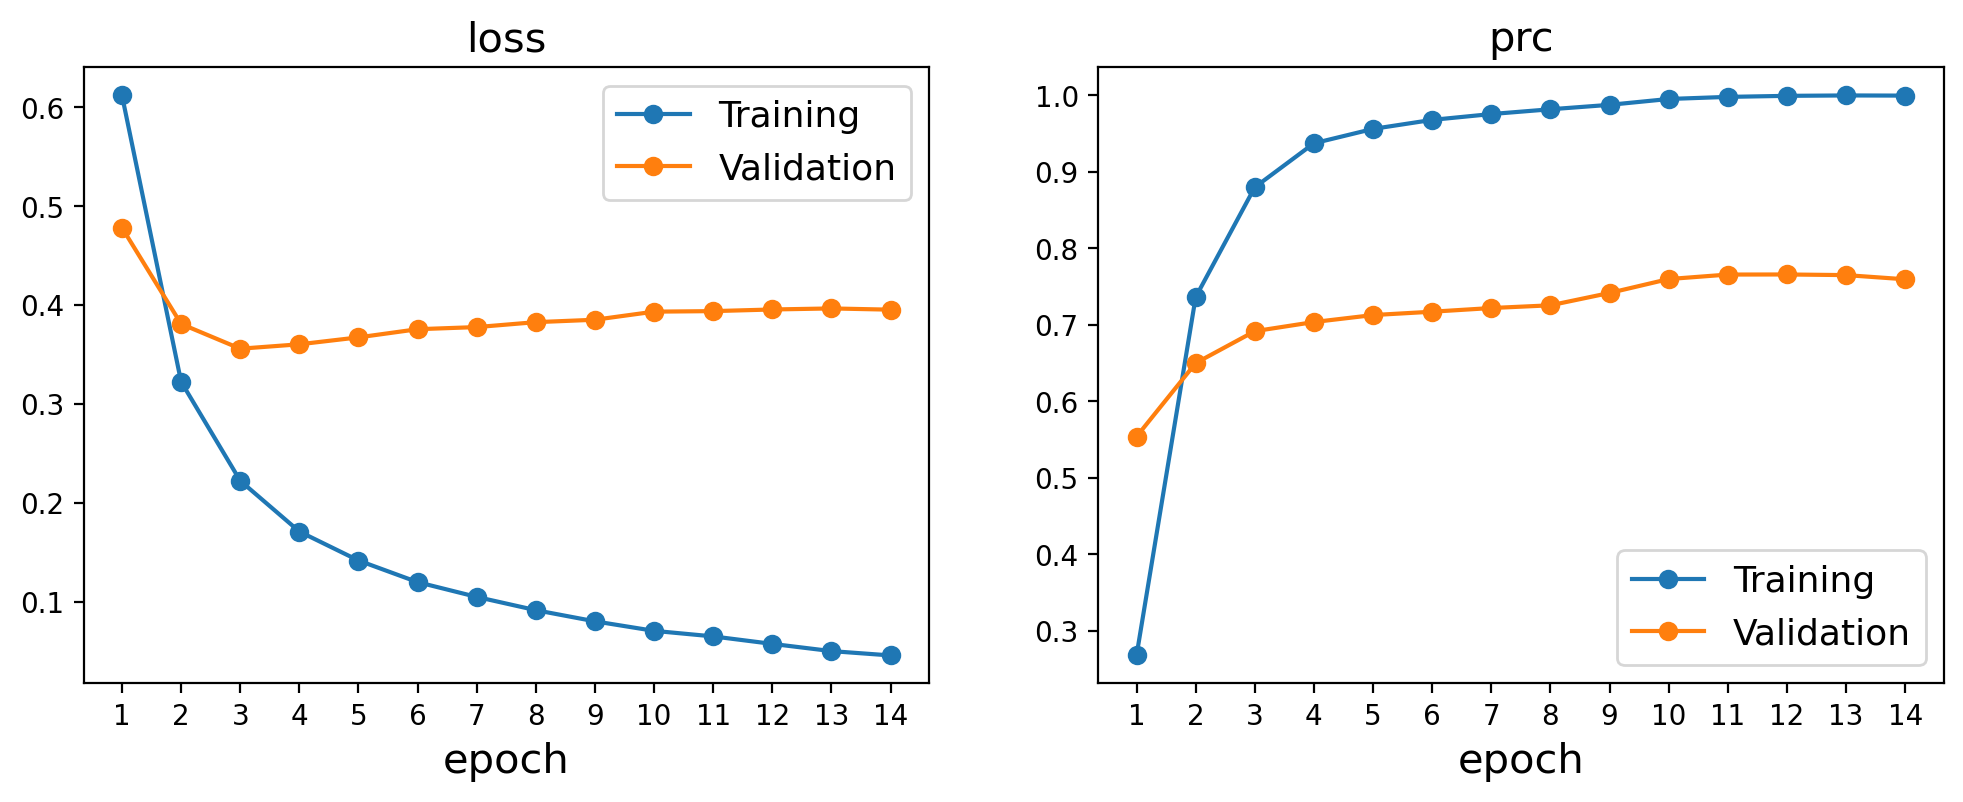

In [199]:
# all features tuning
train_data=[X_train_all_std, y_train]
n_features=len(all_features)
hidden_layer_sizes=[30]
activation='relu'
optimizer='Adam'
learning_rate=0.005
num_epochs=50
batch=64

model = mlp_train(num_epochs, batch, train_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 40)                2600      
                                                                 
 Output (Dense)              (None, 1)                 41        
                                                                 
Total params: 2641 (10.32 KB)
Trainable params: 2641 (10.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 [==============================] - 1s 170ms/step - loss: 0.8207 - prc: 0.2894 - val_loss: 0.5623 - val_prc: 0.6334
Epoch 2/50
7/7 [==============================] - 0s 39ms/step - loss: 0.4131 - prc: 0.6852 - val_loss: 0.3837 - val_prc: 0.7725
Epoch 3/50
7/7 [==============================] - 0s 34ms/step - loss: 0.2730 - prc: 0.8209 - val_loss: 0.3346 - val_prc: 0.7963
Epoch 4/50
7/7 [=========

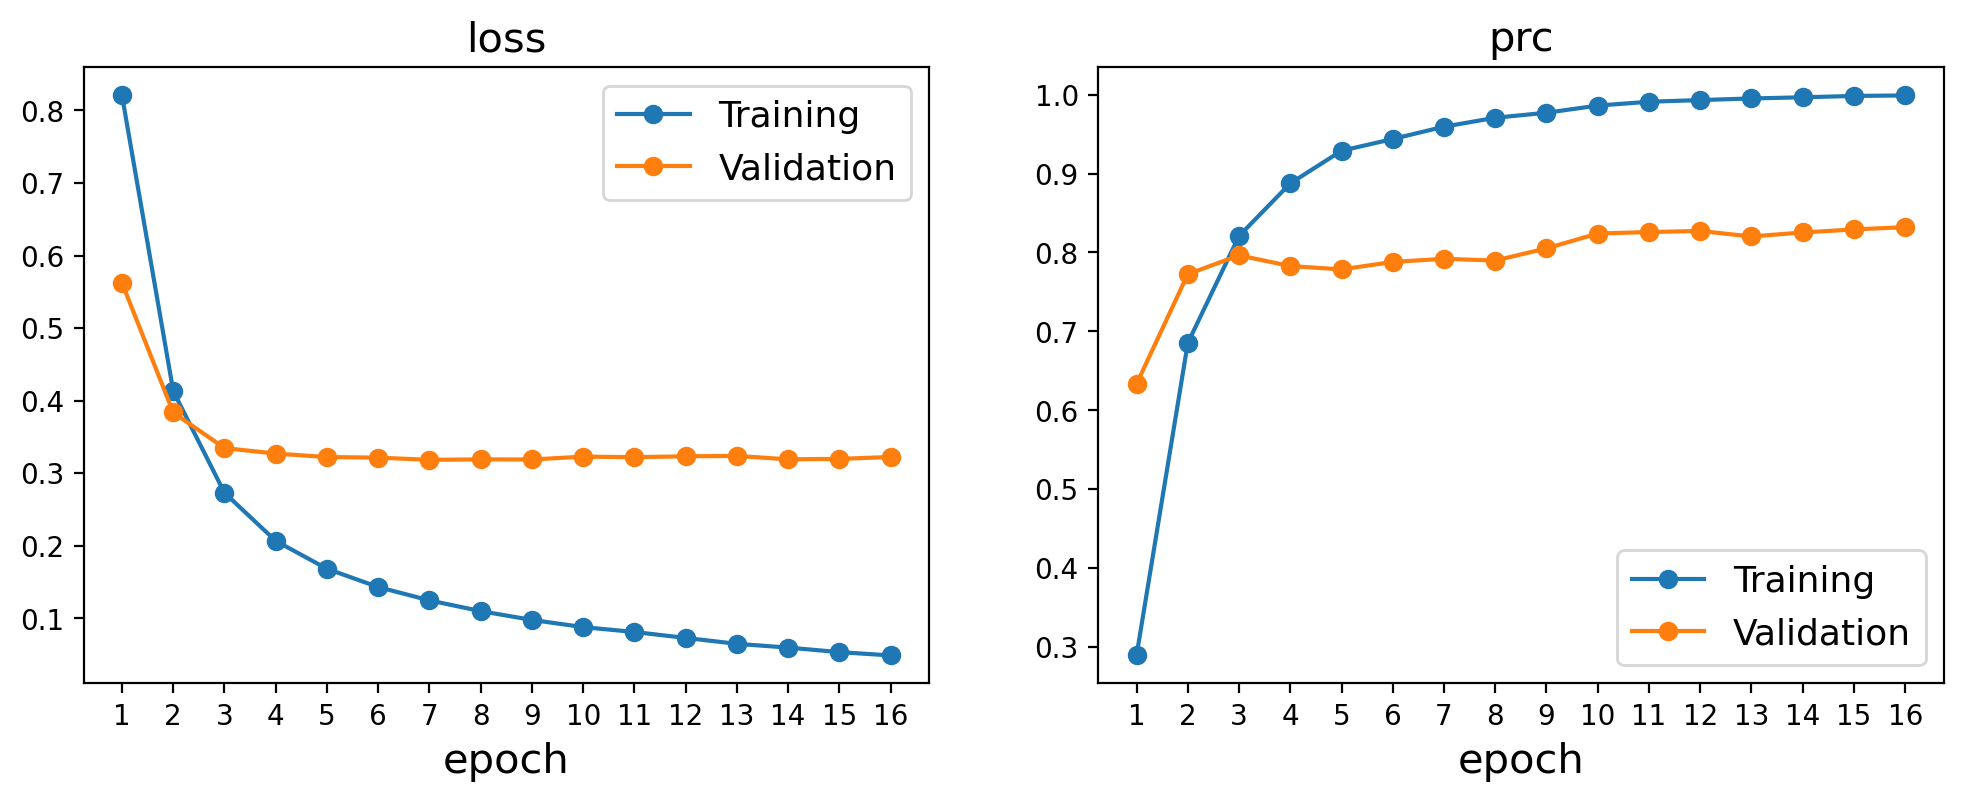

In [200]:
# all features tuning
train_data=[X_train_all_std, y_train]
n_features=len(all_features)
hidden_layer_sizes=[40]
activation='relu'
optimizer='Adam'
learning_rate=0.005
num_epochs=50
batch=64

model = mlp_train(num_epochs, batch, train_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 30)                1950      
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 1981 (7.74 KB)
Trainable params: 1981 (7.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 [==============================] - 1s 166ms/step - loss: 0.8107 - prc: 0.3413 - val_loss: 0.7724 - val_prc: 0.4957
Epoch 2/50
7/7 [==============================] - 0s 38ms/step - loss: 0.7773 - prc: 0.3487 - val_loss: 0.7453 - val_prc: 0.4984
Epoch 3/50
7/7 [==============================] - 0s 29ms/step - loss: 0.7450 - prc: 0.3572 - val_loss: 0.7239 - val_prc: 0.5025
Epoch 4/50
7/7 [===========

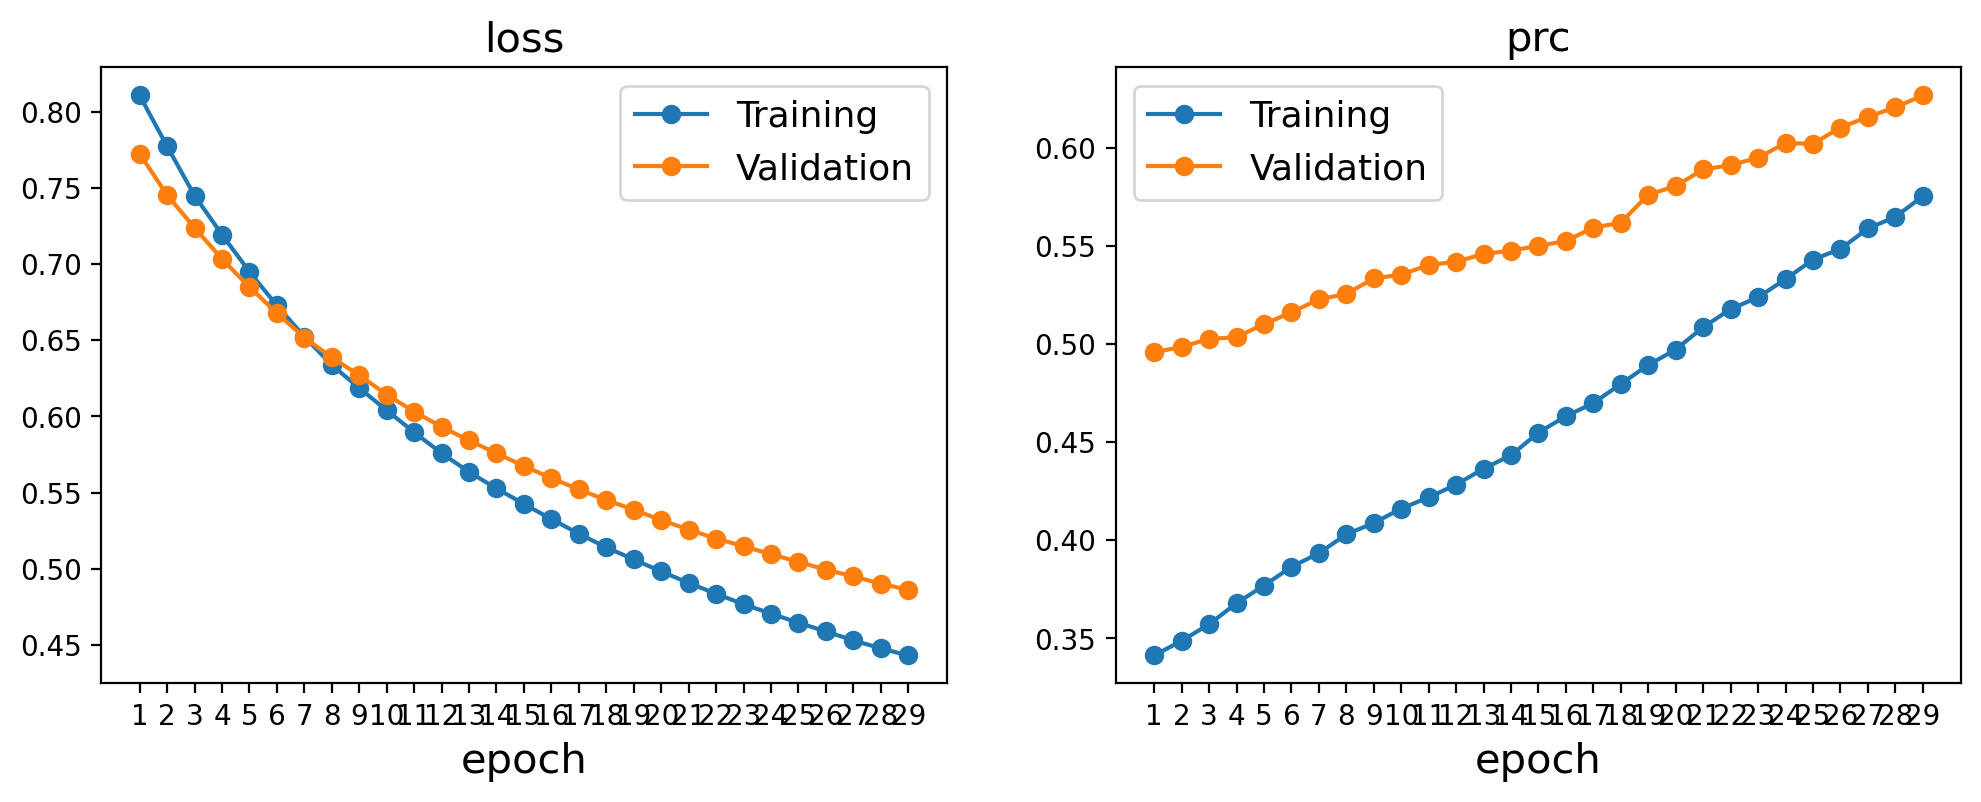

In [201]:
# all features tuning
train_data=[X_train_all_std, y_train]
n_features=len(all_features)
hidden_layer_sizes=[30]
activation='relu'
optimizer='SGD'
learning_rate=0.005
num_epochs=50
batch=64

model = mlp_train(num_epochs, batch, train_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 30)                1950      
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 1981 (7.74 KB)
Trainable params: 1981 (7.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 [==============================] - 1s 155ms/step - loss: 0.5180 - prc: 0.2517 - val_loss: 0.3826 - val_prc: 0.7249
Epoch 2/50
7/7 [==============================] - 0s 50ms/step - loss: 0.2436 - prc: 0.7773 - val_loss: 0.3249 - val_prc: 0.7898
Epoch 3/50
7/7 [==============================] - 0s 32ms/step - loss: 0.1739 - prc: 0.8589 - val_loss: 0.3167 - val_prc: 0.8071
Epoch 4/50
7/7 [===========

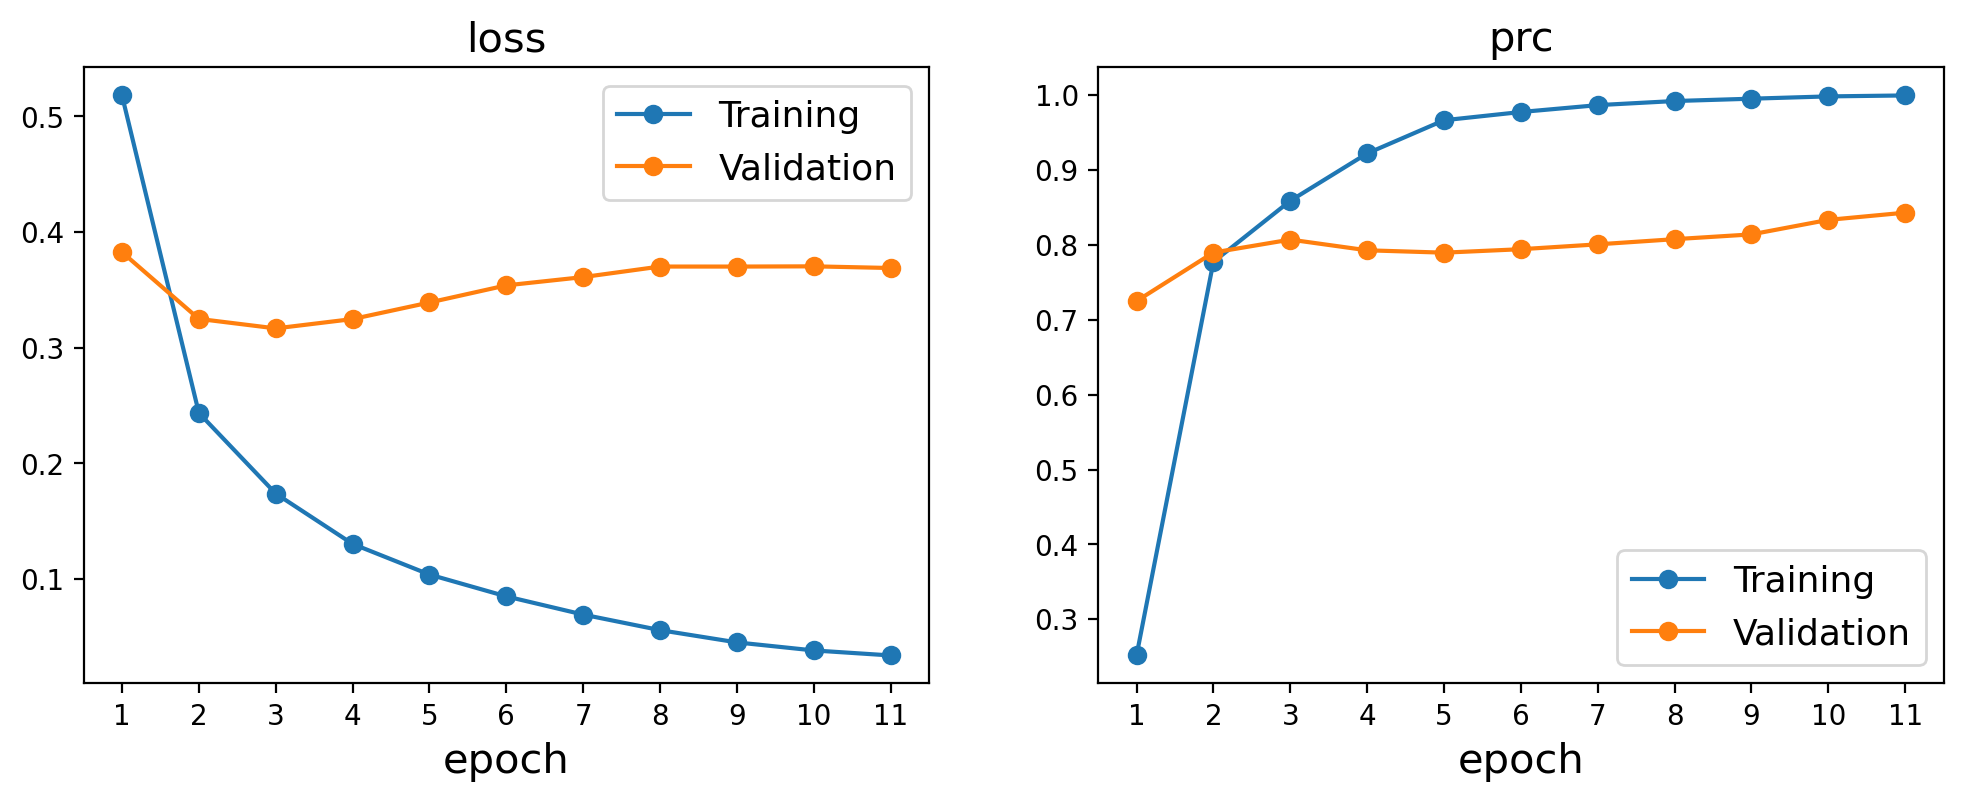

In [202]:
# all features tuning
train_data=[X_train_all_std, y_train]
n_features=len(all_features)
hidden_layer_sizes=[30]
activation='relu'
optimizer='Adam'
learning_rate=0.01
num_epochs=50
batch=64

model = mlp_train(num_epochs, batch, train_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 30)                1950      
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 1981 (7.74 KB)
Trainable params: 1981 (7.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
13/13 [==============================] - 2s 99ms/step - loss: 0.6908 - prc: 0.2925 - val_loss: 0.4262 - val_prc: 0.6867
Epoch 2/50
13/13 [==============================] - 0s 26ms/step - loss: 0.3138 - prc: 0.7091 - val_loss: 0.3367 - val_prc: 0.7878
Epoch 3/50
13/13 [==============================] - 0s 21ms/step - loss: 0.2280 - prc: 0.8256 - val_loss: 0.3130 - val_prc: 0.7901
Epoch 4/50
13/13 [====

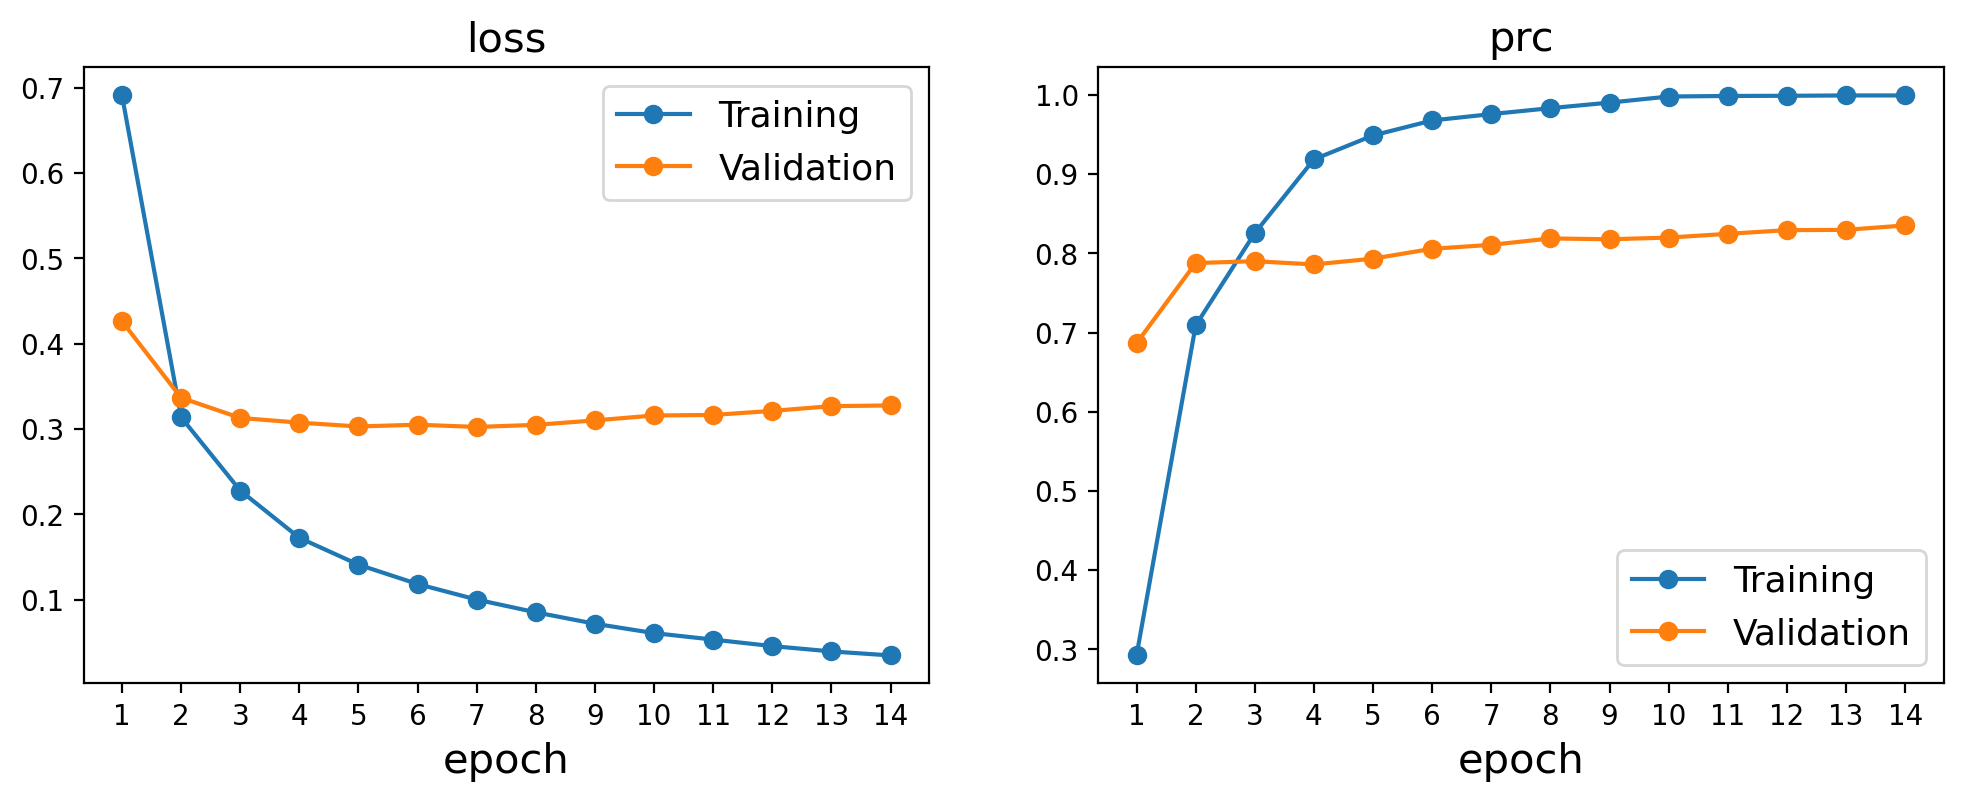

In [203]:
# all features tuning
train_data=[X_train_all_std, y_train]
n_features=len(all_features)
hidden_layer_sizes=[30]
activation='relu'
optimizer='Adam'
learning_rate=0.005
num_epochs=50
batch=32

model = mlp_train(num_epochs, batch, train_data)

### Ablation Table for Different Hyperparameters

hidden_layer_sizes: {[30], [40]}

optimizer: {'SGD', 'Adam'} 

learning_rate= {0.005, 0.01} 

batch: {32, 64} 

<font color="red">3,3</font>

| Training Loss | Validation Loss | Training AUC-PRC | Validation AUC-PRC | Hidden Layer | Optimizer | Learning Rate | Batch Size |
|:-:            |:-:              | :-:              |:-:                 |:-:           |:-:        |:-:            |:-:         |
| 0.0459        | 0.3955          | 0.9998        | 0.7596                | 30          | Adam       | 0.005         | 64         |
| 0.0489        | 0.0489          | 0.9989        | 0.8321                | <font color="red">40</font>          | Adam       | 0.005         | 64         |
| 0.4430        | 0.4861          | 0.5752        | 0.6265                | 30          | <font color="red">SGD</font>        | 0.005         | 64         | 
| 0.0339        | 0.3688          | 0.9996        | <font color="green">0.8430</font>                | 30          | Adam       | <font color="red">0.01</font>          | 64         |
| 0.0349        | 0.3277          | 0.9994        | 0.8353                | 30          | Adam       | 0.005         | <font color="red">32</font>         |


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_0 (Dense)            (None, 30)                1950      
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 1981 (7.74 KB)
Trainable params: 1981 (7.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
7/7 [==============================] - 2s 177ms/step - loss: 0.6817 - prc: 0.2647 - val_loss: 0.4097 - val_prc: 0.6905
Epoch 2/50
7/7 [==============================] - 0s 58ms/step - loss: 0.2810 - prc: 0.7637 - val_loss: 0.3284 - val_prc: 0.7543
Epoch 3/50
7/7 [==============================] - 0s 37ms/step - loss: 0.1950 - prc: 0.8656 - val_loss: 0.3364 - val_prc: 0.7623
Epoch 4/50
7/7 [===========

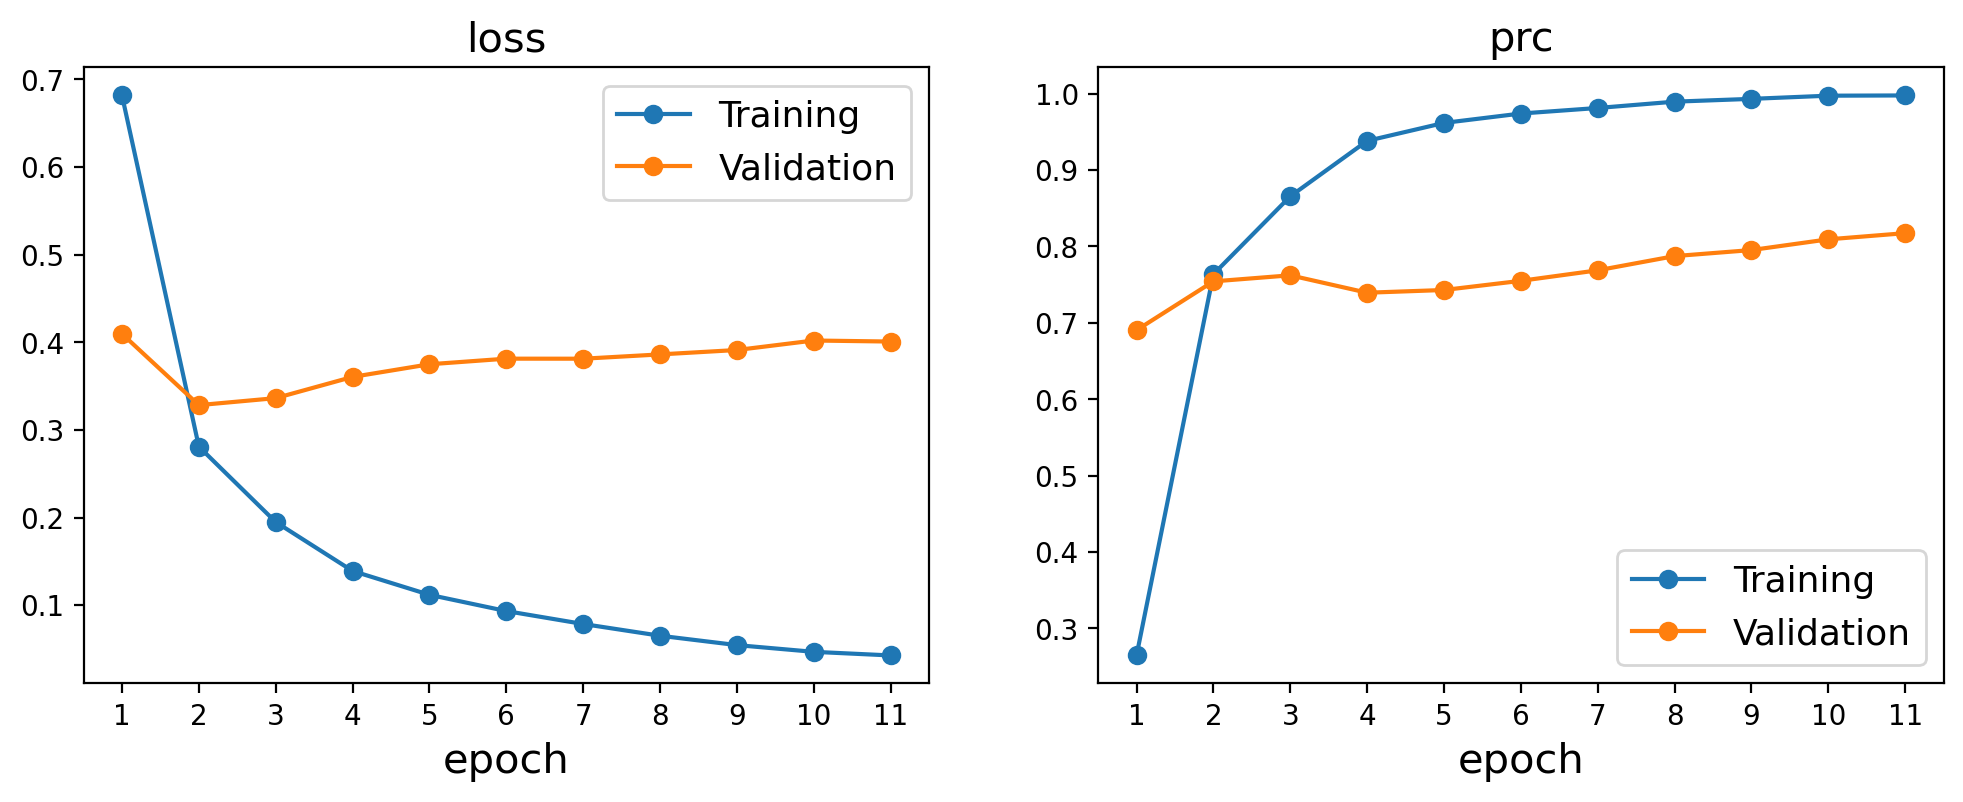

In [208]:
# final run
train_data=[X_train_all_std, y_train]
n_features=len(all_features)
hidden_layer_sizes=[30]
activation='relu'
optimizer='Adam'
learning_rate=0.01
num_epochs=50
batch=64

model = mlp_train(num_epochs, batch, train_data)

### Evaluate Test Set
---

In [209]:
model_eval = model.evaluate(x=X_test_std, y=y_test,
                               verbose=0,
                               return_dict=True)
y_test_pred = model.predict(x=X_test_std, verbose=0)

# print('\nBaseline:          %1.4f' %(np.count_nonzero(y_test == 0)/len(y_test)))
print('\nAUC-PRC:           %1.4f' %(model_eval['prc']))
print('\nLog Loss:          %1.4f' %(model_eval['loss']))
print('Balanced Log Loss: %1.4f' %(balanced_log_loss(y_test, y_test_pred)))


AUC-PRC:           0.8418

Log Loss:          0.1924
Balanced Log Loss: 0.2865


In [211]:
import numpy as np
from sklearn.metrics import auc

# Generate random predictions with a class distribution similar to the dataset
num_samples = 613
true_labels = np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2])
random_scores = np.random.rand(num_samples)

# Sort the scores in descending order (higher scores are considered positive)
sorted_indices = np.argsort(random_scores)[::-1]
sorted_labels = true_labels[sorted_indices]

# Calculate precision and recall for different thresholds
precision = np.cumsum(sorted_labels) / np.arange(1, num_samples + 1)
recall = np.cumsum(sorted_labels) / np.sum(sorted_labels)

# Calculate AUC-PRC using the trapezoidal rule
auc_prc_baseline = auc(recall, precision)

print("Baseline AUC-PRC:", auc_prc_baseline)


Baseline AUC-PRC: 0.2091714740467403


### Evaluate Balanced Test Set
---

In [206]:
# model_bal_eval = model.evaluate(x=X_test_bal_std, y=y_test_bal,
#                                 verbose=0, return_dict=True)

# y_test_bal_pred = model.predict(x=X_test_bal_std, verbose=0)

# print('\nBaseline:          %1.4f' %(np.count_nonzero(y_test_bal == 0)/len(y_test_bal)))
# print('Test Accuracy:     %1.4f' %(model_bal_eval['accuracy']))
# print('\nAUC-PRC:           %1.4f' %(model_bal_eval['prc']))
# print('\nLog Loss:          %1.4f' %(model_bal_eval['loss']))
# print('Balanced Log Loss: %1.4f' %(balanced_log_loss(y_test_bal, y_test_bal_pred)))